/tmp/ipykernel_19483/348548337.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image_array = np.array(image, dtype=np.float32)


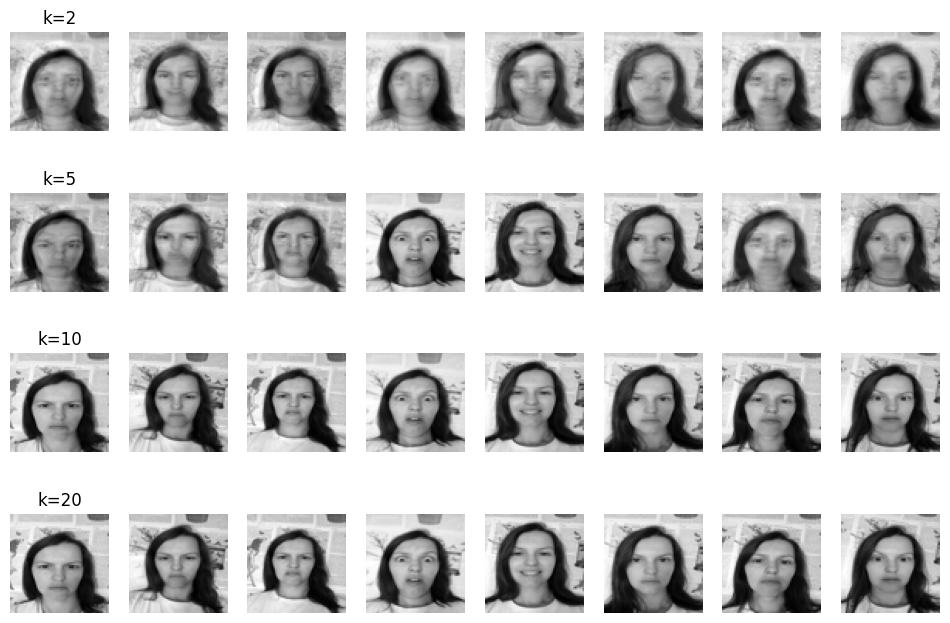

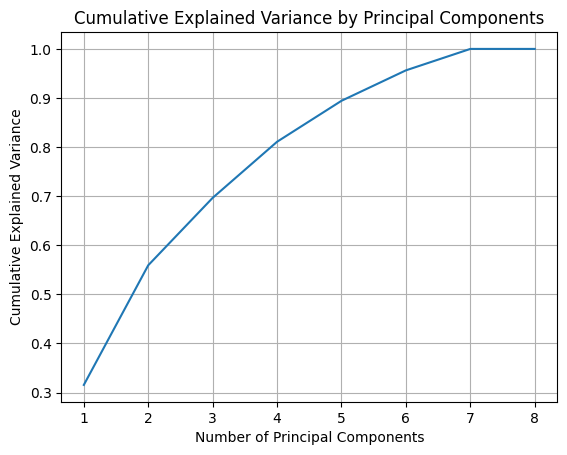

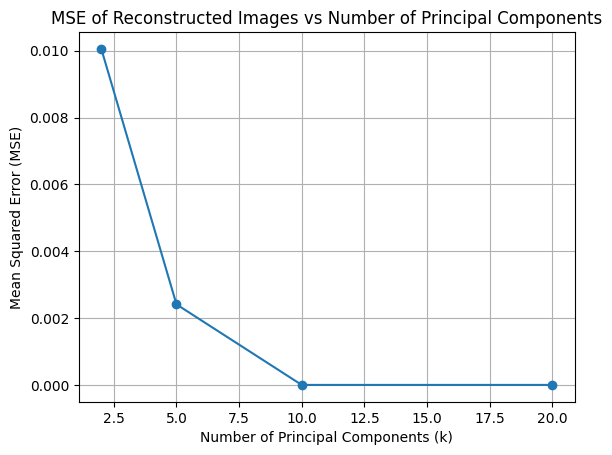

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
data = pd.read_csv("facial-emotion-recognition/facial-emotion-recognition-dataset.csv", sep=";")
image_dir = 'facial-emotion-recognition/images'



def normalize_image(image_path, downsample_size=(64, 64)):  # Resize images to 64x64
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize(downsample_size)  # Resize the image
    image_array = np.array(image, dtype=np.float32)
    normalized_image = image_array / 255.0  # Normalize pixel values
    return normalized_image


# Convert images into a 2D matrix where each row represents a flattened image
def images_to_matrix(image_list):
    flattened_images = [img.flatten() for img in image_list]
    return np.array(flattened_images)

# PCA using Singular Value Decomposition (SVD)
def pca_svd(images, k):
    # Step 1: Compute the mean image
    mean_image = np.mean(images, axis=0)
    
    # Step 2: Subtract the mean image from all images (mean normalization)
    centered_images = images - mean_image
    
    # Step 3: Perform SVD
    U, S, Vt = np.linalg.svd(centered_images, full_matrices=False)
    
    # Step 4: Select the top k components (eigenvectors)
    principal_components = Vt[:k]
    
    # Step 5: Project the original images onto the principal components
    projected_images = np.dot(centered_images, principal_components.T)
    
    # Step 6: Reconstruct the images
    reconstructed_images = np.dot(projected_images, principal_components) + mean_image
    
    return projected_images, principal_components, reconstructed_images, S

# Display reconstructed images for different values of k
def display_reconstructed_images(original_images, reconstructed_images, k_values):
    fig, axes = plt.subplots(len(k_values), len(original_images), figsize=(12, 8))
    
    for i, k in enumerate(k_values):
        for j, (orig_img, recon_img) in enumerate(zip(original_images, reconstructed_images[i])):
            if len(k_values) > 1:
                axes[i, j].imshow(recon_img.reshape(orig_img.shape), cmap='gray')
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_title(f'k={k}')
            else:
                axes[j].imshow(recon_img.reshape(orig_img.shape), cmap='gray')
                axes[j].axis('off')
    
    plt.show()

# Plot cumulative explained variance
def explained_variance(S):
    explained_variance_ratio = (S ** 2) / np.sum(S ** 2)
    cumulative_variance = np.cumsum(explained_variance_ratio)
    return cumulative_variance

def plot_cumulative_variance(cumulative_variance):
    plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance)
    plt.title('Cumulative Explained Variance by Principal Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

# Compute Mean Squared Error (MSE) between original and reconstructed images
def mse(original_images, reconstructed_images):
    return np.mean((original_images - reconstructed_images) ** 2)

# Plot MSE against k
def plot_mse_vs_k(k_values, mse_values):
    plt.plot(k_values, mse_values, marker='o')
    plt.title('MSE of Reconstructed Images vs Number of Principal Components')
    plt.xlabel('Number of Principal Components (k)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.grid(True)
    plt.show()

# Set up the data
sample_set_id = 0
emotion_images = ['Anger.jpg', 'Contempt.jpg', 'Disgust.jpg', 'Fear.jpg', 'Happy.jpg', 'Neutral.jpg', 'Sad.jpg', 'Surprised.jpg']
image_dir = 'facial-emotion-recognition/images'

# Load and normalize the images
normalized_images = []
for emotion in emotion_images:
    image_path = os.path.join(image_dir, f"{sample_set_id}", emotion)
    normalized_img = normalize_image(image_path)
    normalized_images.append(normalized_img)

# Convert the list of images into a 2D matrix (where each row is a flattened image)
image_matrix = images_to_matrix(normalized_images)

# Experiment with different values of k (number of principal components)
k_values = [2, 5, 10, 20]  # You can adjust this list
reconstructed_images_set = []
mse_values = []

# Perform PCA for different k values
for k in k_values:
    projected_images, principal_components, reconstructed_images, S = pca_svd(image_matrix, k)
    reconstructed_images_set.append(reconstructed_images)
    mse_value = mse(image_matrix, reconstructed_images)
    mse_values.append(mse_value)

# Display reconstructed images for different k values
display_reconstructed_images(normalized_images, reconstructed_images_set, k_values)

# Plot the variance explained by the principal components
cumulative_variance = explained_variance(S)
plot_cumulative_variance(cumulative_variance)

# Plot the MSE for different values of k
plot_mse_vs_k(k_values, mse_values)